## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#conclusion)


<a id='intro'></a>
### Introduction

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

#set seed value to initialize the pseudo-random number generator
random.seed(42)

`1.` Now, let's read in the `ab_data.csv` data. We'll store it in a dataframe `df`.

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Number of rows in the dataset:

In [3]:
df.shape[0]

294478

c. Number of unique users in the dataset:

In [4]:
df.user_id.nunique()

290584

d. Proportion of users converted:

In [5]:
df['converted'].mean()

0.11965919355605512

e. Number of times the `new_page` and `treatment` don't line up:

In [6]:
df.loc[(df['landing_page'] == 'new_page') 
       == (df['group'] != 'treatment')].count()[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Let's delete those rows altogether.  

a. Let's store the new dataframe in **df2**:

In [8]:
df2 = df.drop(df.loc[(df['landing_page'] == 'new_page') 
       == (df['group'] != 'treatment')].index)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Let's assess the new dataframe for any duplicated values that we may need to delete.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
print(df2[df2.duplicated(subset=['user_id'],keep="first")])

      user_id                   timestamp      group landing_page  converted
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0


c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. We'll remove one of the rows with a duplicate `user_id`, but we'll store it in the same dataframe, **df2**.

In [13]:
df2 = df2.drop(df2[df2.duplicated(['user_id'])].index)

`4.` Now, let's take a look at some parameters of our dataset.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
obs_old = (df2.loc[(df2.group == 'control') & 
         (df2.converted == 1)].count()[0] / df2.shape[0]) / df2['group'].value_counts(normalize=True)[0]
obs_old

0.12035647925125594

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
obs_new = (df2.loc[(df2.group == 'treatment') & 
         (df2.converted == 1)].count()[0] / df2.shape[0]) / df2['group'].value_counts(normalize=True)[0]
obs_new

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
df2['landing_page'].value_counts(normalize=True)[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**The probability that an individual converted given that they are in the control group is approximately 12.04% while the probabiliy of an individual converting given that they are in the treatment group is approx. 11.88%. Unfortunately, the results aren't significant enough to determine whether to keep the old webpage or replace with the new one. The conversion rate difference is only slightly higher for the control group viewing the old page (+0.16%). In order to clearly assess whether the e-commerce company should make changes to its website, let's perform an A/B test.**

<a id='ab_test'></a>
### Part II - A/B Test

`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should the null and alternative hypotheses be?

$$H_0: p_{new} - p_{old} \leq 0 $$ 
 $$H_1: p_{new} - p_{old} &gt; 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br>

Use the cells below to provide the necessary parts of this simulation.<br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
new_cr = df2['converted'].mean()
new_cr

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
old_cr = df2['converted'].mean()
old_cr

0.11959708724499628

c. What is $n_{new}$?

In [20]:
n_new = df2.landing_page.value_counts()[0]
n_new

145310

d. What is $n_{old}$?

In [21]:
n_old = df2.landing_page.value_counts()[1]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.choice(2, size=n_new, p=[new_cr, (1-new_cr)])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.choice(2, size=n_old, p=[old_cr, (1-old_cr)])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
(new_page_converted.sum() / n_new) - (old_page_converted.sum() / n_old)

0.0018948172143882225

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [25]:
p_diffs = []

for _ in range(10000):
    new_cr_test = np.random.choice(2, size=n_new, p=[new_cr, (1-new_cr)])
    old_cr_test = np.random.choice(2, size=n_old, p=[old_cr, (1-old_cr)])
    
    p_new = new_cr_test.sum() / n_new
    p_old = old_cr_test.sum() / n_old
    
    p_diffs.append(p_new - p_old)

i. Plot a histogram of the **p_diffs**.

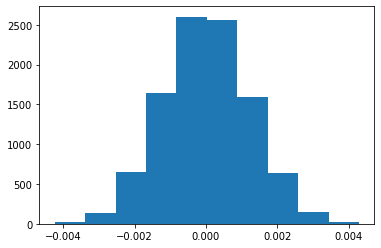

In [26]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
# compute p_diff of the convert rate for p_new and p_old based on the ab_data.csv dataset
ab_p_diff = obs_new - obs_old

# convert p_diffs to a NumPy array
p_diffs = np.array(p_diffs)

# Simulate distribution under the null hypothesis
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

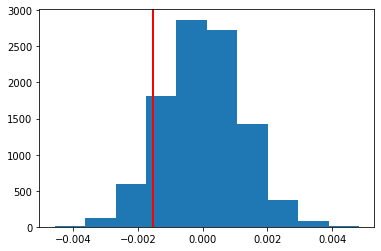

In [28]:
# Plot null distribution
plt.hist(null_vals)
plt.axvline(ab_p_diff,c='r',linewidth = 2);

In [29]:
# computer p-value
(null_vals > ab_p_diff).mean()

0.9023

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The value that we just computed is called the [p-value](https://www.investopedia.com/terms/p/p-value.asp), the probability of obtaining results as extreme as the observed results of a statistical hypothesis test, assuming that the null hypothesis is correct. Here, given the fact that the p-value is rather large, it suggests that we shouldn't move away from the null hypothesis. It means that the test isn't showing strong enough statistical significance to replace the old page with the new one.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [30]:
import statsmodels.api as sm

sum_old_page_converted = df.query('landing_page == "old_page"')['converted'].sum()
sum_new_page_converted = df.query('landing_page == "new_page"')['converted'].sum()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.

In [31]:
z_score, p_value = sm.stats.proportions_ztest([sum_new_page_converted,sum_old_page_converted],
                                              [n_new, n_old],alternative='larger')
(z_score, p_value)

(-1.394390551291367, 0.9184001500898661)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The [z-score](https://www.khanacademy.org/math/ap-statistics/density-curves-normal-distribution-ap/measuring-position/v/comparing-with-z-scores) is a measure that indicates how many standard deviations we are away from the mean (in this case, approximately -1.39). The raw score is below the mean of the distributed values under the null hypothesis, suggesting that the conversion rate of the treatment group viewing the new page isn't higher than the conversion rate of the control group viewing the old webpage. This conclusion supports the results found earlier when we calculated the p-value. Therefore, the result isn't statistically significant to justify making changes to the page.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be achieved by performing regression.<br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**To predict two possible outcomes, we need to perform a logistic regression. In this case, we are looking to determine the probability of the expected result for the page conversion rate (conversion or no conversion).**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
# Create dummy variables for the `group` column
df2[['control','ab_page']] = pd.get_dummies(df2['group'])

# Drop 'control' column because encoded variable will appear under the 'ab_page' column
df2 = df2.drop('control', axis=1)

# Set the intercept
df2['intercept'] = 1

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [33]:
#Fit a logistic regression
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [34]:
# print results summary of the model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 24 Apr 2020   Pseudo R-squ.:               8.077e-06
Time:                        18:44:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?

**The p-value associated with ab_page is 0.19. The value differs from the value computed in Part II because the p-value computed here is two-sided. It is computed on both sides of the normal distribution because in this case, the null hypothesis is that p_old is equal to p_new and the alternative hypothesis is that p_old differs from p_new.**

**In other words:** 


$$H_0: p_{new} = p_{old}$$ 
 $$H_1: p_{new} \neq p_{old}$$

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Based on the dataset, it would be a good idea to conduct a time series analysis to analyze the influence of the time of day on the probability of converting, whether it is to the old page or the new one. One danger of adding additional terms into the regression model is the likelihood of overfitting the model by attempting to estimate too many parameters from a sample size that is too small. Overfitting is a condition where a statistical model begins to describe the random error in the data rather than the relationships between variables. One symptom of an overfitted model is an R-squared value that is too high.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. We'll read in the **countries.csv** dataset and merge together the ab_data and countries datasets on the approporiate rows.

Does it appear that country had an impact on conversion? Provide the statistical output as well as a written response to answer this question.

In [35]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [36]:
# Create the necessary dummy variables and concatenate to the dataframe
dummy_var = pd.get_dummies(df_new['country'])
df_new = pd.concat([df_new, dummy_var], axis = 1)

In [37]:
### Fit Your Linear Model And Obtain the Results
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'US','UK']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 24 Apr 2020   Pseudo R-squ.:               1.521e-05
Time:                        18:44:05   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
US             0.0408      0.027      1.518      0.129      -0.012       0.093
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
==============================================================================
"""

In [38]:
np.exp(0.0408), np.exp(0.0507)

(1.0416437559600236, 1.052007243765014)

Based on the p-value, the country variable doesn't appear to be a relevant indicator of the conversion rate. By exponentiating the coefficients to determine the multiplicative change in the odds of a "1" for every one unit increase of the variable, we see that it is only 1.04 and 1.05 times more likely that an individual will convert whether they're based in the US or the UK, respectively.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion. Provide the summary results, and your conclusions based on the results.

In [39]:
df_new['UK_new_page'] = df_new['ab_page'].where((df_new['ab_page'] == 1) & (df_new['UK'] == 1), 0)
df_new['US_new_page'] = df_new['ab_page'].where((df_new['ab_page'] == 1) & (df_new['US'] == 1), 0)

In [40]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'UK_new_page', 'US_new_page']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 24 Apr 2020   Pseudo R-squ.:               1.082e-05
Time:                        18:44:06   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.3164
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -1.9926      0.008   -252.910      0.000      -2.008      -1.977
UK_new_page     0.0112      0.018      0.626      0.532      -0.024       0.046
US_new_page    -0.0144      0.012     -1.155      0.248      -0.039       0.010
===============================================================================
"""

In [41]:
np.exp(0.0112), 1/np.exp(-0.0144)

(1.011262954811771, 1.0145041794607625)

Here, we notice that individuals based in the UK viewing the new page are 1.01 times more likely to convert. The same rate applies to individuals based in the US viewing the new page. If we look at the p-value, we realize that the variables inputted in this model aren't statistically significant. Therefore, country doesn't seem to be a significant factor to determine the conversion rate. 

<a id='conclusion'></a>
## Conclusion

In this project, we analyzed the results of an A/B test performed by an e-commerce website. The objective was to determine the probability of converting after seeing the old webpage or the new page. For that purpose, we tested the feature on two groups: a control group and a treatment (or experiment) one. The control group viewed the old page while the treatment group viewed the new one.

After setting our null and alternative hypotheses to be:
$$ H_0: p_{new} \leq p_{old} $$
$$ H_1: p_{new} &gt; p_{old} $$

We simulated the test 10,000 times on a sample distribution of **ab_test** population. 

By plotting the distribution from the null and comparing against the actual observed difference in conversion rates, the results didn't prove to be statistically significant enough to justify making changes to the website. With a p-value of approx. 0.9, we would fail to reject the null and keep the old webpage in place. We also used the built-in Python module statsmodels and arrived at the same conclusion.

By fitting a logistic regression model, we seek to predict two possible outcomes: conversion or no conversion. We see from the results summary table above that the likelihood of converting given that an individual was in the treatment group isn't statistically significant with a p-value of 0.19 (two-sided), confirming once again that we should stick with the old webpage.

Lastly, we added a country variable to our regression model to see whether the region where individuals were located affected the conversion rate. With a p-value over the conventional threshold of 0.05, we would conclude here that the region isn't a determining factor contributing to the conversion rate.

### Resources

* https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.choice.html 
* https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html
* https://towardsdatascience.com/the-dummys-guide-to-creating-dummy-variables-f21faddb1d40
* https://statisticsbyjim.com/regression/r-squared-too-high/